In [2]:
# Global imports
import glob
import random
import matplotlib.pyplot as plt
import json
%matplotlib inline

import seaborn
import mpld3
from mpld3 import plugins, fig_to_html
import numpy as np
import pescador
import os

seaborn.set()
np.set_printoptions(precision=4, suppress=True)
mpld3.enable_notebook()

import biggie
import optimus
import datatools
import models as M

pltargs = dict(interpolation='nearest', aspect='equal', 
               cmap=plt.cm.gray_r,
               origin='lower')

/usr/local/lib/python3.5/site-packages/theano/configparser.py:80: DeprecationWarning: The SafeConfigParser class has been renamed to ConfigParser in Python 3.2. This alias will be removed in future versions. Use ConfigParser directly instead.
  'PID': str(os.getpid()),


/usr/local/lib/python3.5/site-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/usr/local/lib/python3.5/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


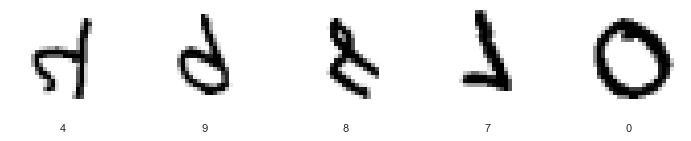

In [3]:
# let's load the data and take a look at some digits.
train, valid, test = datatools.load_mnist_npz("/Users/ejhumphrey/mnist/mnist.npz")
num_imgs = 5
fig = plt.figure(figsize=(num_imgs*2, 2))
for n, idx in enumerate(np.random.permutation(len(train[1]))[:num_imgs]):
    ax = fig.add_subplot(101 + 10*num_imgs + n)
    ax.imshow(train[0][idx, 0], **pltargs)
    ax.set_xlabel("{0}".format(train[1][idx]))
    ax.set_xticks([])    
    ax.set_yticks([]);
plt.tight_layout()

In [ ]:
nn_idxs = json.load(open("/Users/ejhumphrey/mnist/full_train_neighbors.json"))

In [ ]:
cstream = datatools.neighbor_stream(train[0], nn_idxs)
xs = next(cstream)

num_imgs = 3
fig = plt.figure(figsize=(num_imgs*2, 2))
for n, (name, x) in enumerate(xs.items()):
    ax = fig.add_subplot(101 + 10*num_imgs + n)
    ax.imshow(x.squeeze(), **pltargs)
    ax.set_xlabel("{0}".format(name))
    ax.set_xticks([])    
    ax.set_yticks([]);
plt.tight_layout()
plt.show()

In [ ]:
batch = pescador.buffer_batch(cstream, 50)

In [ ]:
param_file = "/Users/ejhumphrey/mnist_2d_params_nns2.hdf5"

In [ ]:
trainer, predictor = M.pwrank()

In [ ]:
if os.path.exists(param_file):
    os.remove(param_file)
params = biggie.Stash(param_file)
driver = optimus.Driver(
    graph=trainer, name='nns-20',
    parameter_cache=params)

In [ ]:
res = driver.fit(
    source=batch, 
    hyperparams=dict(learning_rate=0.02, 
                     margin_same=0.0, margin_diff=1), 
    max_iter=25000, print_freq=250, save_freq=250)

In [ ]:
params = biggie.Stash(param_file)
last_key = sorted(params.keys())[-1]
predictor.param_values = params.get(last_key)

In [ ]:
idx = np.random.permutation(len(valid[0]))[:2000]
x_in = valid[0][idx]
y_true = valid[1][idx]
# predictor.param_values = trainer.param_values
z_out = predictor(x_in=x_in)['z_out']

In [ ]:
imgfiles = [datatools.generate_imagename(i, y) 
            for i, y in enumerate(idx, y_true)]
url_base = "https://raw.githubusercontent.com/ejhumphrey/mnistifolds/master/images/valid/"
labels = ['<img src="file://{}{}" width=100 height=100>'.format(url_base, img) 
          for img in imgfiles]

In [ ]:
labels[0]

In [ ]:
# Replace https://... for offline use
# file:///usr/local/lib/python3.5/site-packages/mpld3/js/
palette = seaborn.color_palette("Set3", 10)
colors = np.asarray([palette[y] for y in y_true])
fig = plt.figure(figsize=(10, 10))
ax = fig.gca()
handle = ax.scatter(z_out.T[0], z_out.T[1], 
                    c=colors, s=75, alpha=0.66)

tooltip = plugins.PointHTMLTooltip(
    handle, labels,
    voffset=10, hoffset=10)

plugins.connect(fig, tooltip)
# plt.tight_layout()
# plt.show()
# print(fig_to_html(fig))
with open("/Users/ejhumphrey/temp.html", 'w') as fp:
    mpld3.save_html(fig, fp)

In [ ]:
params.close()